In [1]:
# This notebook should be run on google colab. Huggingface's transformers does not like lokal notebooks

# Installing

In [11]:
# Installments

In [12]:
!pip install transformers

In [13]:
!pip install datasets

In [14]:
!pip install tensorflow-addons

# Imports

In [15]:
from google.colab import drive
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
import tensorflow_addons as tfa
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score,classification_report
import numpy as np
import random

In [16]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change the value of base_path to the directory that contains the data.
BASE_PATH = '/content/drive/MyDrive/Thesis/RobBert/'

# Machine learning

In [17]:
with open('texts.pkl', 'rb') as f:
  text_list = pickle.load(f)
with open('labels.pkl', 'rb') as f:
  label_list = pickle.load(f)

In [18]:
def train_model(text, labels, optimization_function, num_epochs, model_name, batchsize, reset_graph=True, take_weights=True):
  # We train several models in succession, so we need to reset the tensorflow graph
  K.clear_session()
  if reset_graph == True:
    tf.compat.v1.reset_default_graph
    tf.compat.v1.Session()
  # Inititalize model & tokenizer
  tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")
  model = TFRobertaForSequenceClassification.from_pretrained("pdelobelle/robbert-v2-dutch-base", num_labels = 9)
  # Encode labels into integers
  le = LabelEncoder()
  labels_encoded = le.fit_transform(labels)

  all_labels = np.unique(labels)
  labels_transformed = le.transform(all_labels)
  translation_dict = {x: y for x, y in zip(all_labels, labels_transformed)}

  # Split into train, test, and validation set
  train_texts, test_texts, train_labels, test_labels = train_test_split(text, labels_encoded, test_size=.2, random_state = 420)
  train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size = 0.2, random_state = 420)

  print(f'len training set: {len(train_texts)}')
  print(f'len validation set: {len(val_texts)}')
  print(f'len test set: {len(test_texts)}')
  # Tokenize text 
  train_encodings = tokenizer(train_texts, truncation=True, padding=True)
  test_encodings = tokenizer(test_texts, truncation=True, padding=True)
  val_encodings = tokenizer(val_texts, truncation=True, padding=True)

  # Transform data into tensorflow-dataset objects
  train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
  )).shuffle(len(train_texts))
  test_dataset = tf.data.Dataset.from_tensor_slices((
      dict(test_encodings),
      test_labels
  )).shuffle(len(test_texts))
  val_dataset = tf.data.Dataset.from_tensor_slices((
      dict(val_encodings),
      val_labels
  )).shuffle(len(val_texts))
  optimizer = optimization_function
  model.compile(optimizer=optimizer, 
                loss=model.compute_loss, 
                metrics=['accuracy'] 
                ) 
  # Start TRaining
  print('--------------------STARTING TRAINING--------------------')
  if take_weights == False:
    history = model.fit(train_dataset.batch(batchsize), 
                        epochs=num_epochs, 
                        batch_size=batchsize, 
                        validation_data=val_dataset.batch(batchsize)
                        )
  else:
    class_weights = dict(enumerate(compute_class_weight('balanced', np.unique(labels), labels)))
    history = model.fit(train_dataset.batch(batchsize), 
                        epochs=num_epochs, batch_size=batchsize, 
                        validation_data=val_dataset.batch(batchsize), 
                        class_weight=class_weights
                        )
  model.save_pretrained(BASE_PATH+f"{model_name}")
  # Save history as well for plotting later on
  with open(BASE_PATH+f"{model_name}_HISTORY.pkl", 'wb') as f:
    pickle.dump(history.history, f)

  return model, history, test_dataset, test_encodings, test_labels, translation_dict, class_weights

def evaluate_performance(model, history, test_dataset, batchsize):
  # Evaluate using test set
  print('--------------------STARTING EVALUATION--------------------')

  # Plot training vs. validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  predictions = tf.nn.softmax(model.predict(test_dataset.batch(batchsize)).logits)
  test_labels = np.concatenate([y for x, y in test_dataset.batch(batchsize)], axis=0)
  print(f"sklearn accuracy: {accuracy_score(test_labels, np.argmax(predictions, axis=1))}")
  print(classification_report(test_labels,np.argmax(predictions, axis=1)))
  print(f"micro f1 score: {f1_score(test_labels, np.argmax(predictions, axis=1), average='micro')}")
  print(f"macro f1 score: {f1_score(test_labels, np.argmax(predictions, axis=1), average='macro')}")

  del model

In [33]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0962607095991547)
model, history, dataset, test_encodings, test_labels, translation_dict, class_weights_dict = train_model(text_list, label_list, optimizer, 10, 'final_model', 4, take_weights=True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


len training set: 764
len validation set: 191
len test set: 239
--------------------STARTING TRAINING--------------------
Epoch 1/10
191/191 [==============================] - 102s 460ms/step - loss: 19.2030 - accuracy: 0.1243 - val_loss: 7.0640 - val_accuracy: 0.0785
Epoch 2/10
191/191 [==============================] - 85s 448ms/step - loss: 15.5571 - accuracy: 0.0942 - val_loss: 7.7335 - val_accuracy: 0.1518
Epoch 3/10
191/191 [==============================] - 85s 448ms/step - loss: 18.4740 - accuracy: 0.0733 - val_loss: 17.1775 - val_accuracy: 0.0785
Epoch 4/10
191/191 [==============================] - 86s 448ms/step - loss: 14.8200 - accuracy: 0.0864 - val_loss: 5.4002 - val_accuracy: 0.2513
Epoch 5/10
191/191 [==============================] - 86s 448ms/step - loss: 12.4241 - accuracy: 0.1113 - val_loss: 8.2871 - val_accuracy: 0.2513
Epoch 6/10
191/191 [==============================] - 86s 448ms/step - loss: 15.4496 - accuracy: 0.0995 - val_loss: 12.2213 - val_accuracy: 0.0105

--------------------STARTING EVALUATION--------------------


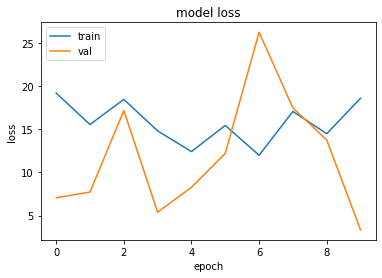

sklearn accuracy: 0.28870292887029286
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        41
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         3
           7       0.29      1.00      0.45        69
           8       0.00      0.00      0.00        12

    accuracy                           0.29       239
   macro avg       0.04      0.12      0.06       239
weighted avg       0.08      0.29      0.13       239

micro f1 score: 0.28870292887029286
macro f1 score: 0.0560064935064935


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
evaluate_performance(model, history, dataset, 6)

In [21]:
# This dict contains the encodings the labelencoder used to replace the string labels with.
translation_dict

{'Aanvaarding': 0,
 'Angst': 1,
 'Anticipatie': 2,
 'Boosheid (woede)': 3,
 'Geen emoti': 4,
 'Verassing': 5,
 'Verdriet': 6,
 'Vreugde': 7,
 'Walging': 8}

# Random Classification

In [23]:
weights = [class_weights_dict[key] for key in class_weights_dict]
weights = [i / sum(weights) for i in weights]

In [30]:
def perform_random_classification(n):
  return [np.random.choice(np.arange(0,9), p = weights) for i in range(n)]

def compute_f1_score(y_true, y_pred):
  return f1_score(y_true, y_pred, average='macro')

def experiments(n, test_data):
  accuracies = []
  f1_scores = []
  for i in range(n):
    random_classification = perform_random_classification(len(test_data))
    accuracies.append(accuracy_score(test_data, random_classification))
    f1_scores.append(compute_f1_score(test_data, random_classification))
    
  return sum(f1_scores) / len(f1_scores), sum(accuracies) / len(accuracies)


In [28]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robbert-v2-dutch-base")

le = LabelEncoder()
labels_encoded = le.fit_transform(label_list)

all_labels = np.unique(label_list)
labels_transformed = le.transform(all_labels)
translation_dict_rc = {x: y for x, y in zip(all_labels, labels_transformed)}

# Split into train, test, and validation set
train_texts, test_texts, train_labels, test_labels = train_test_split(text_list, labels_encoded, test_size=.2, random_state = 420)

In [31]:
average_f1, average_accuracy = experiments(1000000, test_labels)

In [32]:
print(f'Average accuracy over 1M experiments of a random classifier: {average_accuracy}')
print(f'Average f1 score (macro average) over 1M experiments of a random classifier: {average_f1}')

Average accuracy over 1M experiments of a random classifier: 0.03413941841005807
Average f1 score (macro average) over 1M experiments of a random classifier: 0.040651677583027124
